- This notebook is me thinking out loud. 
- Neater version starts with bike_analysis_lin_reg_part_3.ipynb

In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [341]:
df_daily = pd.read_csv('cleaned_data/df_daily.csv')

In [342]:
X = df_daily.drop('Unnamed: 0', axis = 1)
X = X.drop(['wind_speed', 'casual', 'registered', 'dew_point', 'year_month','app_temp_cat', 'date', 'year', 'calendar_week'], axis = 1)
y = df_daily['total']


In [343]:
X.head(2)

,season,month,holiday,day_of_week,work_day,weather_sit,temp,app_temp,humidity,total
0,winter,1,no,sat,no,misty,8.2,8.0,80.6,985
1,winter,1,no,sun,no,misty,9.1,7.3,69.6,801


- Convert "season", "holiday", "day_of_week", "work_day", "weather_sit" to numerical values to create heatmap. 

In [344]:
X['weather_sit'].unique()

array(['misty', 'clear', 'bit wet'], dtype=object)

In [345]:
season_dict = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}
holiday_dict = {'no':0, 'yes':1}
day_of_week_dict = {'mon':0, 'tue':1, 'wed':2, 'thu':3, 'fri':4, 'sat':5, 'sun': 6}
work_day_dict = {'no':0, 'yes':1}
weather_sit_dict = {'misty': 0, 'clear': 1, 'bit wet':2}

X['season'] = X['season'].map(season_dict)
X['holiday'] = X['holiday'].map(holiday_dict)
X['day_of_week'] = X['day_of_week'].map(day_of_week_dict)
X['work_day'] = X['work_day'].map(work_day_dict)
X['weather_sit'] = X['weather_sit'].map(weather_sit_dict)



In [346]:
X.head(2)

,season,month,holiday,day_of_week,work_day,weather_sit,temp,app_temp,humidity,total
0,0,1,0,5,0,0,8.2,8.0,80.6,985
1,0,1,0,6,0,0,9.1,7.3,69.6,801


<h3> Correlation heat map </h3>

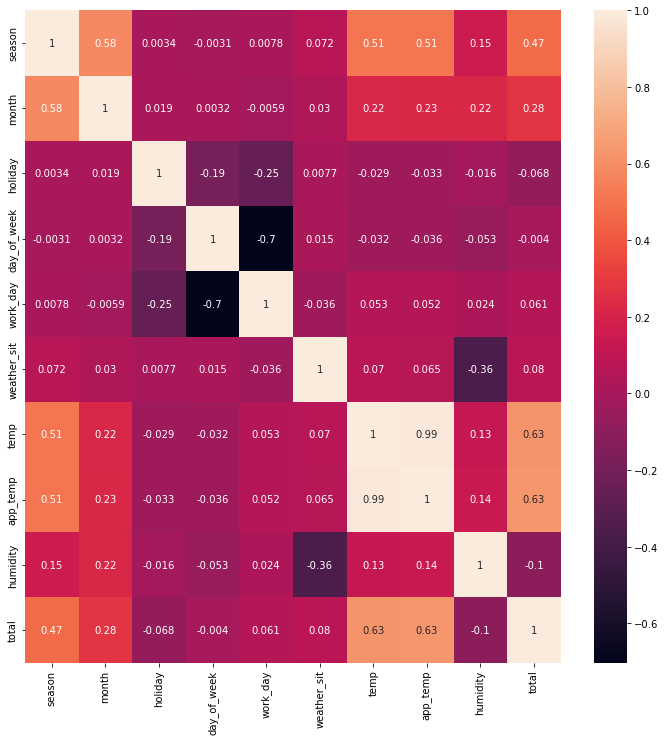

In [347]:
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(X.corr(), annot = True)
plt.show()

In [348]:
# Find pairs with correlation greater than 0.6
X.corr()[(X.corr()>0.6) | (X.corr()<-0.6)]

,season,month,holiday,day_of_week,work_day,weather_sit,temp,app_temp,humidity,total
season,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,NaN,NaN,NaN,1.000000,-0.702587,NaN,NaN,NaN,NaN,NaN
work_day,NaN,NaN,NaN,-0.702587,1.000000,NaN,NaN,NaN,NaN,NaN
weather_sit,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
temp,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.991716,NaN,0.627553
app_temp,NaN,NaN,NaN,NaN,NaN,NaN,0.991716,1.000000,NaN,0.631150
humidity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
total,NaN,NaN,NaN,NaN,NaN,NaN,0.627553,0.631150,NaN,1.000000


Highly correlated pairs: 
- calendar_week & month
- work_day and day_of_week
- app_temp and temp
- dew_point and temp
- dew_point and app_temp

<h3> One-hot encoding for categorical variables </h3>

In [349]:
X.head(2)

,season,month,holiday,day_of_week,work_day,weather_sit,temp,app_temp,humidity,total
0,0,1,0,5,0,0,8.2,8.0,80.6,985
1,0,1,0,6,0,0,9.1,7.3,69.6,801


Categorical variables: 
- season
- month
- holiday
- day_of_week
- work_day
- weather_sit


In [350]:
X_enc = X.copy(deep = True)

In [351]:
# Encode season
season_encoder = OneHotEncoder()
encoded_season = pd.DataFrame(season_encoder.fit_transform(X[['season']]).toarray())
season_encoder.categories_
encoded_season.columns = ['winter', 'spring', 'summer', 'autumn']
X_enc = X.join(encoded_season)

In [352]:
# Encode month
month_encoder = OneHotEncoder()
encoded_month = pd.DataFrame(month_encoder.fit_transform(X[['month']]).toarray())
month_encoder.categories_
encoded_month.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
X_enc = X_enc.join(encoded_month)



In [353]:
# Encode holiday
holiday_encoder = OneHotEncoder()
encoded_holiday = pd.DataFrame(holiday_encoder.fit_transform(X[['holiday']]).toarray())
holiday_encoder.categories_

encoded_holiday.columns = ['holiday_no', 'holiday_yes']
X_enc = X_enc.join(encoded_holiday)



In [354]:
# Encode day_of_week
dow_encoder = OneHotEncoder()
encoded_dow = pd.DataFrame(dow_encoder.fit_transform(X[['day_of_week']]).toarray())
dow_encoder.categories_
encoded_dow.columns = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']
X_enc = X_enc.join(encoded_dow)



In [355]:
# Encode work_day

work_day_encoder = OneHotEncoder()
encoded_work_day = pd.DataFrame(work_day_encoder.fit_transform(X[['work_day']]).toarray())
work_day_encoder.categories_
encoded_work_day.columns = ['work_day_no', 'work_day_yes']
X_enc = X_enc.join(encoded_work_day)

In [356]:
# Encode weather_sit

weather_sit_encoder = OneHotEncoder()
encoded_weather_sit = pd.DataFrame(weather_sit_encoder.fit_transform(X[['weather_sit']]).toarray())
weather_sit_encoder.categories_
encoded_weather_sit.columns = ['weather_sit_0', 'weather_sit_1', 'weather_sit_2']
X_enc = X_enc.join(encoded_weather_sit)

In [357]:
X_enc.head()

,season,month,holiday,day_of_week,work_day,weather_sit,temp,app_temp,humidity,total,...,wed,thur,fri,sat,sun,work_day_no,work_day_yes,weather_sit_0,weather_sit_1,weather_sit_2
0,0,1,0,5,0,0,8.2,8.0,80.6,985,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0,1,0,6,0,0,9.1,7.3,69.6,801,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0,1,0,0,1,1,1.2,-3.5,43.7,1349,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0,1,0,1,1,1,1.4,-2.0,59.0,1562,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0,1,0,2,1,1,2.7,-0.9,43.7,1600,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [358]:
X_enc.columns

Index(['season', 'month', 'holiday', 'day_of_week', 'work_day', 'weather_sit',
       'temp', 'app_temp', 'humidity', 'total', 'winter', 'spring', 'summer',
       'autumn', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec', 'holiday_no', 'holiday_yes', 'mon', 'tue', 'wed',
       'thur', 'fri', 'sat', 'sun', 'work_day_no', 'work_day_yes',
       'weather_sit_0', 'weather_sit_1', 'weather_sit_2'],
      dtype='object')

In [359]:
X_enc = X_enc.drop(['season', 'month', 'holiday', 'day_of_week', 'work_day', 'weather_sit'], axis = 1)

In [360]:
X_enc

,temp,app_temp,humidity,total,winter,spring,summer,autumn,Jan,Feb,...,wed,thur,fri,sat,sun,work_day_no,work_day_yes,weather_sit_0,weather_sit_1,weather_sit_2
0,8.2,8.0,80.6,985,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,9.1,7.3,69.6,801,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,1.2,-3.5,43.7,1349,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.4,-2.0,59.0,1562,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2.7,-0.9,43.7,1600,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,3.9,-1.0,65.3,2114,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
727,3.9,0.8,59.0,3095,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
728,3.9,-0.0,75.3,1341,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
729,4.0,-0.7,48.3,1796,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [361]:
predictors = X_enc.corr()['total'].reset_index()
predictors['total'] = predictors['total'].abs()
predictors = predictors.sort_values(by = 'total', ascending = False)
predictors

,index,total
3,total,1.000000
1,app_temp,0.631150
0,temp,0.627553
4,winter,0.520572
8,Jan,0.366090
6,summer,0.347928
9,Feb,0.277764
32,weather_sit_1,0.252870
33,weather_sit_2,0.239958
13,Jun,0.195866


<h3> Feature selection / elimination using ViF </h3>

In [371]:
X_vif = X_enc
X_vif = X_vif.drop('total', axis = 1)
X_vif['intercept'] = 1
X_vif


,temp,app_temp,humidity,winter,spring,summer,autumn,Jan,Feb,Mar,...,thur,fri,sat,sun,work_day_no,work_day_yes,weather_sit_0,weather_sit_1,weather_sit_2,intercept
0,8.2,8.0,80.6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
1,9.1,7.3,69.6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1
2,1.2,-3.5,43.7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
3,1.4,-2.0,59.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
4,2.7,-0.9,43.7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,3.9,-1.0,65.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
727,3.9,0.8,59.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
728,3.9,-0.0,75.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
729,4.0,-0.7,48.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1


In [372]:
vif = pd.DataFrame()
vif['variable'] = X_vif.columns
vif['vif'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif = vif[vif['variable']!='intercept']
vif

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,variable,vif
0,temp,76.584729
1,app_temp,67.045267
2,humidity,1.936281
3,winter,inf
4,spring,inf
5,summer,inf
6,autumn,inf
7,Jan,inf
8,Feb,inf
9,Mar,inf


<h3> Feature Selection via backward elimination </h3>

- choose significance level threshold as 0.05
- p-value = 0.95
- columns with p-value over 0.05 will be considered insignificant

<h4> Split dataset </h4>

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3, random_state=101)

<h4> Scale data </h4>

In [279]:
# Scale data
scaler = StandardScaler()
scaler.fit(X_train[['temp', 'app_temp', 'humidity']])

# Only want to scale continuous variables
X_train_scaled = X_train
X_train_scaled [['temp', 'app_temp', 'humidity']] = scaler.transform(X_train_scaled [['temp', 'app_temp', 'humidity']])

X_test_scaled = X_test
X_test_scaled [['temp', 'app_temp', 'humidity']] = scaler.transform(X_test_scaled [['temp', 'app_temp', 'humidity']])


In [280]:
#adding a column of ones for b0x0
X_train_scaled = np.append(arr = np.ones((len(X_train_scaled),1)).astype(int), values = X_train_scaled, axis = 1)

In [281]:
X_train_scaled.shape

(511, 35)

In [297]:
list1 = list(range(10))

list1.remove(3)
list1

[0, 1, 2, 4, 5, 6, 7, 8, 9]

In [293]:
# Copy X_train_scaled in order to perform feature selection
index_list = list(range(35))
X_opt = X_train_scaled[:,index_list ]

regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.804e+30
Date:                Mon, 11 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:53:04   Log-Likelihood:                 12836.
No. Observations:                 511   AIC:                        -2.562e+04
Df Residuals:                     486   BIC:                        -2.552e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.847e-13   2.17e-13     -0.853      0.394    -6.1e-13    2.41e-13
x1         -5.002e-12   1.94e-12     -2.574      0.010   -8.82e-12   -1.18e-12
x2          3.183e-12   1.88e-12      1.695      0.091   -5.07e-13    6.87e-12
x3         -2.647e-13   1.99e-13     -1.331      0.184   -6.55e-13    1.26e-13
x4             1.0000   1.05e-16   9.53e+15      0.000       1.000       1.000
x5         -7.816e-13   3.49e-13     -2.239      0.026   -1.47e-12   -9.56e-14
x6         -3.624e-13   1.87e-13     -1.934      0.054   -7.31e-13    5.78e-15
x7          6.821e-13    3.9e-13      1.749      0.081   -8.43e-14    1.45e-12
x8          2.274e-13   2.13e-13      1.069      0.286   -1.91e-13    6.45e-13
x9         -1.137e-13   4.23e-13     -0.269      0.788   -9.44e-13    7.17e-13
x10        -9.663e-13   4.22e-13     -2.291      0.022    -1.8e-12   -1.38e-13
x11         6.821e-13   4.36e-13      1.565      0.118   -1.74e-13    1.54e-12
x12        -3.411e-13   3.99e-13     -0.856      0.393   -1.12e-12    4.42e-13
x13        -3.411e-13   4.39e-13     -0.778      0.437    -1.2e-12    5.21e-13
x14         2.558e-13   3.96e-13      0.646      0.519   -5.22e-13    1.03e-12
x15         3.979e-13   4.24e-13      0.938      0.349   -4.35e-13    1.23e-12
x16         1.315e-13   4.11e-13      0.320      0.749   -6.76e-13    9.39e-13
x17        -2.842e-13   4.62e-13     -0.616      0.538   -1.19e-12    6.23e-13
x18         2.274e-13   3.93e-13      0.579      0.563   -5.44e-13    9.99e-13
x19         5.969e-13   4.92e-13      1.214      0.225   -3.69e-13    1.56e-12
x20         2.274e-13   4.03e-13      0.564      0.573   -5.65e-13    1.02e-12
x21        -1.137e-13   2.97e-13     -0.382      0.702   -6.98e-13    4.71e-13
x22         2.274e-13   3.98e-13      0.572      0.568   -5.54e-13    1.01e-12
x23        -2.274e-13   3.29e-13     -0.691      0.490   -8.73e-13    4.19e-13
x24        -2.274e-13   3.42e-13     -0.666      0.506   -8.99e-13    4.44e-13
x25                 0   3.48e-13          0      1.000   -6.83e-13    6.83e-13
x26        -1.421e-13   3.34e-13     -0.426      0.671   -7.98e-13    5.14e-13
x27        -5.684e-14   3.44e-13     -0.165      0.869   -7.33e-13    6.19e-13
x28         2.842e-13   2.85e-13      0.998      0.319   -2.75e-13    8.44e-13
x29        -4.015e-13   2.88e-13     -1.395      0.164   -9.67e-13    1.64e-13
x30        -1.705e-13   2.05e-13     -0.831      0.406   -5.74e-13    2.32e-13
x31        -7.816e-14   1.36e-13     -0.573      0.567   -3.46e-13     1.9e-13
x32         3.126e-13    3.4e-13      0.918      0.359   -3.56e-13    9.81e-13
x33        -1.421e-13   3.99e-13     -0.356      0.722   -9.27e-13    6.43e-13
x34        -3.695e-13   7.15e-13     -0.517      0.605   -1.77e-12    1.03e-12
==============================================================================
Om

In [294]:
#x25 is highest, so remove it. 
index_list.remove(25)
X_opt = X_train_scaled[:,index_list]

regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.335e+30
Date:                Mon, 11 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:53:15   Log-Likelihood:                 12789.
No. Observations:                 511   AIC:                        -2.553e+04
Df Residuals:                     486   BIC:                        -2.542e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.832e-13   3.01e-13     -1.606      0.109   -1.07e-12    1.08e-13
x1          -5.23e-12   2.13e-12     -2.456      0.014   -9.41e-12   -1.05e-12
x2          3.411e-12   2.06e-12      1.658      0.098   -6.32e-13    7.45e-12
x3         -2.718e-13   2.18e-13     -1.247      0.213      -7e-13    1.56e-13
x4             1.0000   1.15e-16    8.7e+15      0.000       1.000       1.000
x5         -8.953e-13   3.83e-13     -2.336      0.020   -1.65e-12   -1.42e-13
x6         -1.421e-14    2.1e-13     -0.068      0.946   -4.26e-13    3.98e-13
x7          1.023e-12   4.32e-13      2.369      0.018    1.75e-13    1.87e-12
x8          -7.39e-13   2.38e-13     -3.106      0.002   -1.21e-12   -2.72e-13
x9         -1.137e-13   4.63e-13     -0.245      0.806   -1.02e-12    7.96e-13
x10        -5.258e-13   4.62e-13     -1.138      0.256   -1.43e-12    3.82e-13
x11         3.695e-13   4.78e-13      0.773      0.440   -5.69e-13    1.31e-12
x12        -6.253e-13   4.37e-13     -1.431      0.153   -1.48e-12    2.33e-13
x13        -1.421e-13   4.81e-13     -0.296      0.768   -1.09e-12    8.02e-13
x14         3.979e-13   4.34e-13      0.916      0.360   -4.56e-13    1.25e-12
x15                 0   4.65e-13          0      1.000   -9.15e-13    9.15e-13
x16         4.015e-13    4.5e-13      0.892      0.373   -4.83e-13    1.29e-12
x17        -6.253e-13   5.07e-13     -1.234      0.218   -1.62e-12    3.71e-13
x18         5.684e-14   4.31e-13      0.132      0.895   -7.89e-13    9.03e-13
x19        -4.832e-13   5.38e-13     -0.898      0.370   -1.54e-12    5.74e-13
x20        -8.527e-14   4.42e-13     -0.193      0.847   -9.54e-13    7.83e-13
x21         1.705e-13   3.43e-13      0.497      0.619   -5.04e-13    8.45e-13
x22        -4.405e-13   5.28e-13     -0.835      0.404   -1.48e-12    5.96e-13
x23        -9.095e-13   5.84e-13     -1.557      0.120   -2.06e-12    2.38e-13
x24         2.274e-13   5.73e-13      0.397      0.692   -8.99e-13    1.35e-12
x25        -1.165e-12   5.65e-13     -2.063      0.040   -2.28e-12   -5.52e-14
x26        -6.253e-13   5.74e-13     -1.090      0.276   -1.75e-12    5.02e-13
x27         2.842e-13   3.51e-13      0.810      0.418   -4.05e-13    9.74e-13
x28        -6.608e-13   3.56e-13     -1.857      0.064   -1.36e-12    3.85e-14
x29        -3.268e-13   2.21e-13     -1.480      0.140   -7.61e-13    1.07e-13
x30        -9.948e-14   2.52e-13     -0.394      0.694   -5.96e-13    3.97e-13
x31          -5.4e-13   3.83e-13     -1.409      0.159   -1.29e-12    2.13e-13
x32        -1.421e-13   4.43e-13     -0.321      0.748   -1.01e-12    7.28e-13
x33         4.832e-13   7.82e-13      0.618      0.537   -1.05e-12    2.02e-12
==============================================================================
Omnibus:                        7.036   Durbin-Watson:                   0.720
Pr